In [1]:
!pip install -U ultralytics opencv-python matplotlib

# Headless/plot-safe setup for Windows/Jupyter (prevents kernel restarts)
import os
os.environ["MPLBACKEND"] = "Agg"
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

from ultralytics import YOLO
from pathlib import Path
import torch, glob, os, shutil
print("Torch:", torch.__version__, "| CUDA:", torch.cuda.is_available())

Torch: 2.8.0+cpu | CUDA: False


In [2]:
# Your dataset path
DATA_ROOT = Path(r"C:\Users\Owner\datasets\african-wildlife")

# Make/overwrite data.yaml (use forward slashes for YOLO)
yaml_path = DATA_ROOT / "data.yaml"
yaml_text = f"""# YOLO dataset config (African Wildlife)
path: {DATA_ROOT.as_posix()}
train: images/train
val: images/val
names:
  0: buffalo
  1: elephant
  2: rhino
  3: zebra
"""
yaml_path.write_text(yaml_text)
print("Wrote:", yaml_path)
print(yaml_path.read_text())

# Quick structure sanity check
img_exts = {".jpg",".jpeg",".png",".bmp"}
def cnt_imgs(p): return sum(1 for x in (p).rglob("*") if x.suffix.lower() in img_exts)
def cnt_txt(p):  return sum(1 for x in (p).rglob("*.txt"))
print("train images:", cnt_imgs(DATA_ROOT/"images"/"train"),
      "| train labels:", cnt_txt(DATA_ROOT/"labels"/"train"))
print("val   images:", cnt_imgs(DATA_ROOT/"images"/"val"),
      "| val   labels:", cnt_txt(DATA_ROOT/"labels"/"val"))


Wrote: C:\Users\Owner\datasets\african-wildlife\data.yaml
# YOLO dataset config (African Wildlife)
path: C:/Users/Owner/datasets/african-wildlife
train: images/train
val: images/val
names:
  0: buffalo
  1: elephant
  2: rhino
  3: zebra

train images: 1052 | train labels: 1052
val   images: 225 | val   labels: 225


In [3]:
# Continue training properly (safe settings)
model = YOLO("yolov8n.pt")  # you can also start from previous best.pt if you like

In [4]:
results = model.train(
    data=str(yaml_path),
    epochs=10,
    imgsz=512,
    batch=8,
    device=0 if torch.cuda.is_available() else "cpu",
    workers=0,
    cache=False,
    plots=False,           # keep False to avoid kernel restart
    project="runs",
    name="african",
    exist_ok=True,
    save=True,
    save_period=5,
    patience=20
)

model.names

print("Saved weights:", glob.glob("runs/detect/african/weights/*.pt"))

Ultralytics 8.3.237  Python-3.13.5 torch-2.8.0+cpu CPU (Intel Core i5-7300HQ 2.50GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\Owner\datasets\african-wildlife\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=african, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=

Using weights: runs/african/weights/best.pt
Ultralytics 8.3.237  Python-3.13.5 torch-2.8.0+cpu CPU (Intel Core i5-7300HQ 2.50GHz)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 342.3221.9 MB/s, size: 65.6 KB)
val: Scanning C:\Users\Owner\datasets\african-wildlife\labels\val.cache... 225 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 225/225 382.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 1.0it/s 14.3s1.2s
                   all        225        379      0.925      0.876      0.937      0.761
               buffalo         62         89      0.937      0.841      0.948      0.779
              elephant         53         91      0.908      0.863      0.913      0.745
                 rhino         55         85      0.918      0.906       0.95      0.795
                 zebra         59        114      0.936      0.893 

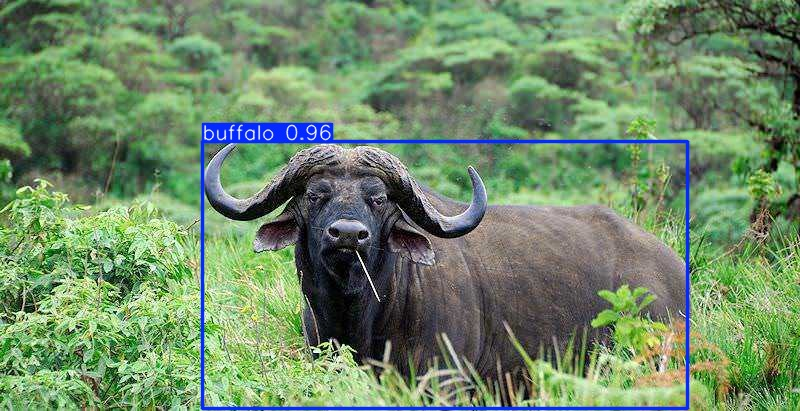

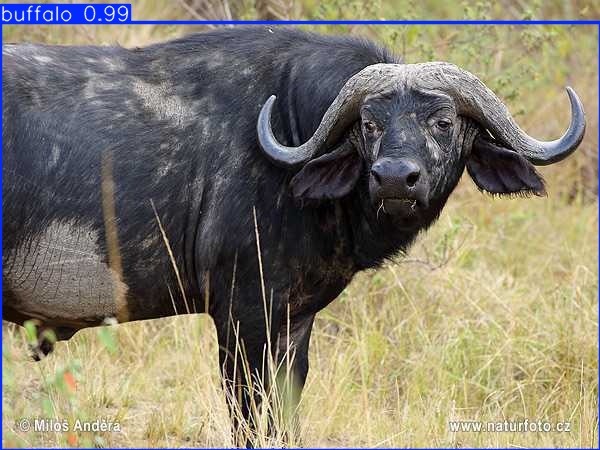

In [5]:
from ultralytics import YOLO
from pathlib import Path
import os, glob
from IPython.display import Image, display

# Robustly pick a weight file (prefer best.pt)
candidates = [
    r"runs/african/weights/best.pt",
    r"runs/african/weights/last.pt",
    r"runs/detect/african/weights/best.pt",
    r"runs/detect/african/weights/last.pt",
]
weight = next((p for p in candidates if os.path.exists(p)), None)
print("Using weights:", weight)

model = YOLO(weight)

# Evaluate
metrics = model.val()
print(metrics)

# Predict on validation images and save visualizations
DATA_ROOT = Path(r"C:\Users\Owner\datasets\african-wildlife")
preds = model.predict(source=str(DATA_ROOT / "images" / "val"), imgsz=512, save=True)
save_dir = preds[0].save_dir if preds else "runs/detect/predict"
print("Predictions saved to:", save_dir)

# Show a couple of predicted images in the notebook
pred_images = glob.glob(os.path.join(save_dir, "*.jpg"))
for p in pred_images[:2]:
    display(Image(filename=p))

In [6]:
from ultralytics import YOLO
from pathlib import Path

model = YOLO("runs/african/weights/best.pt")

# Run prediction on a single image
img_path = r"C:\Users\Owner\datasets\african-wildlife\images\test"
results = model.predict(source=img_path, save=True, imgsz=512)
results[0].show()  # Opens image with detections


image 1/227 C:\Users\Owner\datasets\african-wildlife\images\test\1 (103).jpg: 448x512 1 buffalo, 108.5ms
image 2/227 C:\Users\Owner\datasets\african-wildlife\images\test\1 (121).jpg: 416x512 1 buffalo, 75.0ms
image 3/227 C:\Users\Owner\datasets\african-wildlife\images\test\1 (128).jpg: 352x512 1 buffalo, 70.7ms
image 4/227 C:\Users\Owner\datasets\african-wildlife\images\test\1 (130).jpg: 352x512 1 buffalo, 73.5ms
image 5/227 C:\Users\Owner\datasets\african-wildlife\images\test\1 (131).jpg: 384x512 1 buffalo, 73.3ms
image 6/227 C:\Users\Owner\datasets\african-wildlife\images\test\1 (137).jpg: 512x352 1 buffalo, 65.2ms
image 7/227 C:\Users\Owner\datasets\african-wildlife\images\test\1 (144).jpg: 352x512 1 buffalo, 70.0ms
image 8/227 C:\Users\Owner\datasets\african-wildlife\images\test\1 (154).jpg: 384x512 2 buffalos, 65.6ms
image 9/227 C:\Users\Owner\datasets\african-wildlife\images\test\1 (168).jpg: 352x512 1 buffalo, 75.2ms
image 10/227 C:\Users\Owner\datasets\african-wildlife\images\

In [7]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from ultralytics import YOLO
from pathlib import Path
import glob
import torch

# -----------------------------------
# 1) Load trained YOLO model
# -----------------------------------
weights = "runs/african/weights/best.pt"   # <-- update path if needed
model = YOLO(weights)

# -----------------------------------
# 2) Load validation images + labels
# -----------------------------------
DATA_ROOT = Path(r"C:\Users\lehin\Downloads\african-wildlife")
img_dir = DATA_ROOT / "images" / "val"
label_dir = DATA_ROOT / "labels" / "val"

# Collect image paths
img_paths = []
for ext in ("*.jpg", "*.jpeg", "*.png"):
    img_paths.extend(img_dir.glob(ext))

y_true = []
y_pred = []

# -----------------------------------
# 3) Build ground truth + YOLO predictions
# -----------------------------------
for img_path in img_paths:

    # --- Load ground-truth label file ---
    label_path = label_dir / (img_path.stem + ".txt")
    if not label_path.exists():
        continue

    # Read true labels
    with open(label_path, "r") as f:
        labels = f.read().strip().splitlines()
        for line in labels:
            true_class = int(line.split()[0])
            y_true.append(true_class)

    # --- Predict using YOLO ---
    results = model(img_path, imgsz=512, conf=0.25, verbose=False)
    boxes = results[0].boxes

    if boxes is None:
        continue

    # Read predicted labels
    for b in boxes:
        pred_class = int(b.cls)
        y_pred.append(pred_class)

# -----------------------------------
# 4) Compute Confusion Matrix
# -----------------------------------
class_names = ["Buffalo", "Elephant", "Rhino", "Zebra"]  # <-- update if different

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))

# -----------------------------------
# 5) Plot and SAVE confusion matrix
# -----------------------------------
plt.figure(figsize=(8,6))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=True
)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()

# Save instead of plt.show()
output_path = "confusion_matrix.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")

print(f"Confusion matrix saved to: {output_path}")


Confusion matrix saved to: confusion_matrix.png


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from ultralytics import YOLO
from pathlib import Path
import glob

# ---------------------------
# 1) Paths & model
# ---------------------------
weights = "runs/african/weights/best.pt"   # <-- change if needed
model = YOLO(weights)

# use your TEST images here (or val if you prefer)
DATA_ROOT = Path(r"C:\Users\lehin\Downloads\african-wildlife")
img_dir   = DATA_ROOT / "images" / "val"      # or "test"
label_dir = DATA_ROOT / "labels" / "val"      # or "test"

class_names = ["Buffalo", "Elephant", "Rhino", "Zebra"]  # update if needed

# ---------------------------
# 2) Collect GT + predictions
# ---------------------------
img_paths = []
for ext in ("*.jpg", "*.jpeg", "*.png"):
    img_paths.extend(img_dir.glob(ext))

y_true = []
y_pred = []

# cell_images[(true_class, pred_class)] = [img paths...]
cell_images = {}

for img_path in img_paths:
    # ground-truth labels
    label_path = label_dir / (img_path.stem + ".txt")
    if not label_path.exists():
        continue

    with open(label_path, "r") as f:
        lines = [ln.strip() for ln in f.readlines() if ln.strip()]

    # predict with YOLO
    results = model(img_path, imgsz=512, conf=0.25, verbose=False)
    boxes = results[0].boxes

    # if no detections, skip (or treat as background if you prefer)
    if boxes is None or len(boxes) == 0:
        continue

    # For simplicity: pair each GT object with one predicted object of same index.

    for idx, line in enumerate(lines):
        true_cls = int(line.split()[0])
        y_true.append(true_cls)

        if idx < len(boxes):
            pred_cls = int(boxes[idx].cls)
        else:
            # if fewer predictions than GT, treat as "missed" prediction
            # here we just repeat true_cls so it lands on the diagonal;
            # alternatively you can use a special "background" label.
            pred_cls = true_cls

        y_pred.append(pred_cls)

        # track which images contributed to each cell
        key = (true_cls, pred_cls)
        cell_images.setdefault(key, []).append(str(img_path))

# ---------------------------
# 3) Confusion matrix
# ---------------------------
labels_idx = list(range(len(class_names)))
cm = confusion_matrix(y_true, y_pred, labels=labels_idx)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=True
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (YOLO on test images)")
plt.tight_layout()

out_png = "confusion_matrix.png"
plt.savefig(out_png, dpi=300, bbox_inches="tight")
print("Confusion matrix saved to:", out_png)

# ---------------------------
# 4) Show which images are in each cell
# ---------------------------
print("\nExamples for each (True, Pred) cell:")
for (t, p), paths in cell_images.items():
    print(f"True={class_names[t]:8s}, Pred={class_names[p]:8s}  -> {len(paths)} image(s)")
    # print up to 3 example paths for this cell
    for ex in paths[:3]:
        print("   ", ex)


Confusion matrix saved to: confusion_matrix.png

Examples for each (True, Pred) cell:


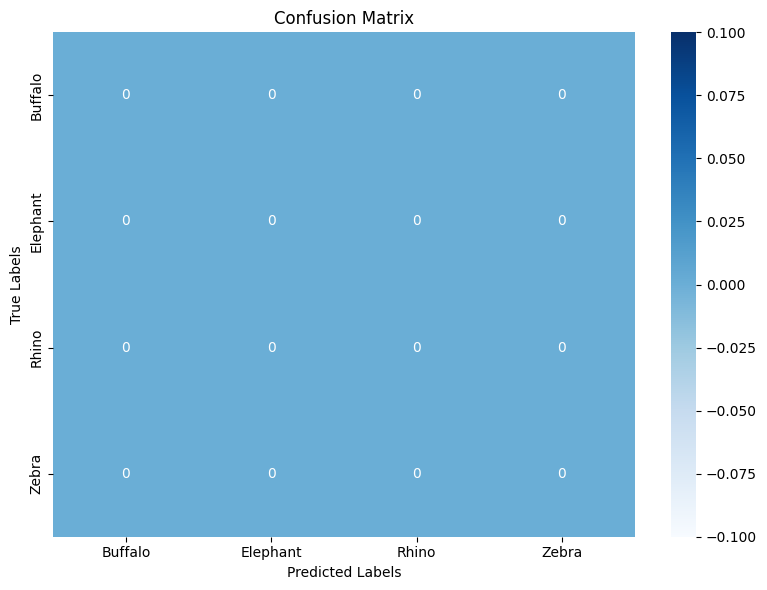

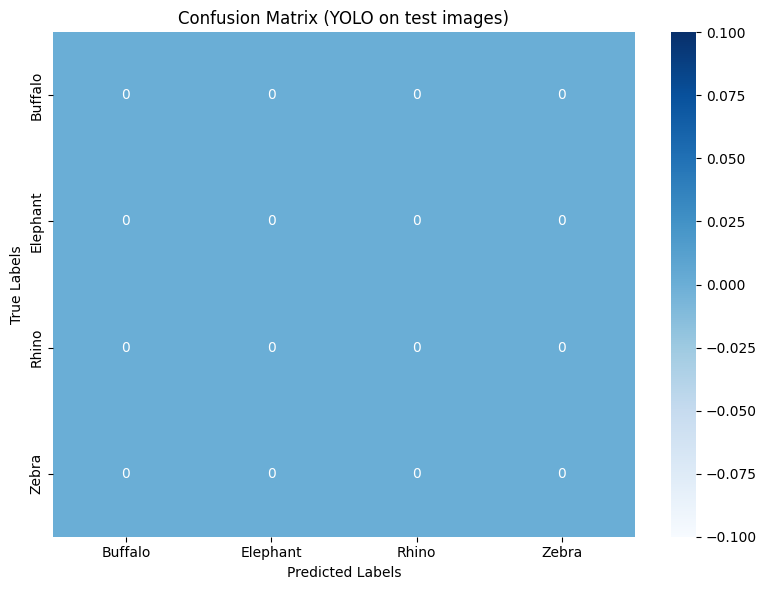

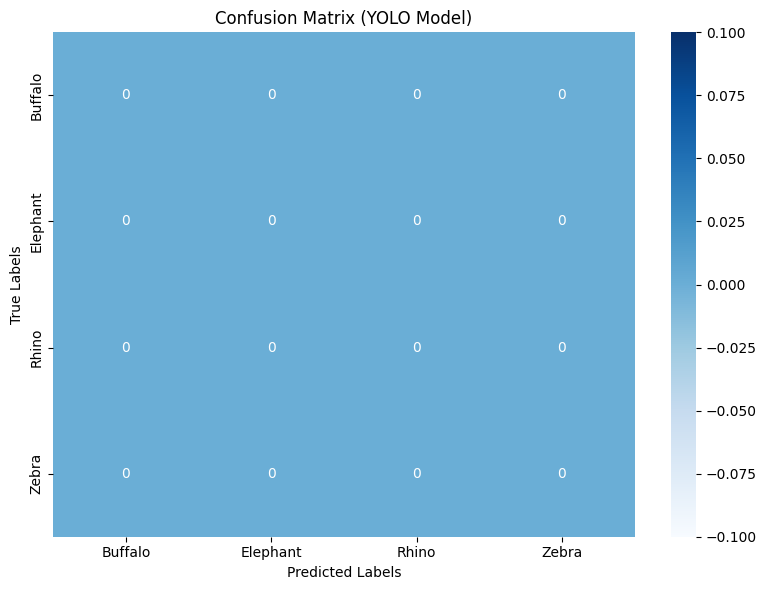

In [10]:
%matplotlib inline

import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from ultralytics import YOLO
from pathlib import Path
import glob

# -----------------------------------
# 1) Load YOLO model
# -----------------------------------
weights = "runs/african/weights/best.pt"   # <-- change if needed
model = YOLO(weights)

# -----------------------------------
# 2) Load test/validation images + labels
# -----------------------------------
DATA_ROOT = Path(r"C:\Users\lehin\Downloads\african-wildlife")
img_dir   = DATA_ROOT / "images" / "val"
label_dir = DATA_ROOT / "labels" / "val"

class_names = ["Buffalo", "Elephant", "Rhino", "Zebra"]  # update if needed 
# Collect image paths
img_paths = []
for ext in ("*.jpg", "*.jpeg", "*.png"):
    img_paths.extend(img_dir.glob(ext))

y_true = []
y_pred = []

# -----------------------------------
# 3) Evaluate all images
# -----------------------------------
for img_path in img_paths:
    
    # Load ground truth
    label_path = label_dir / (img_path.stem + ".txt")
    if not label_path.exists():
        continue

    with open(label_path, "r") as f:
        labels = f.read().strip().splitlines()

    # Predict with YOLO
    results = model(img_path, imgsz=512, conf=0.25, verbose=False)
    boxes = results[0].boxes

    if boxes is None or len(boxes) == 0:
        continue

    # pair each GT with predicted classes
    for idx, line in enumerate(labels):
        true_cls = int(line.split()[0])
        y_true.append(true_cls)

        if idx < len(boxes):
            pred_cls = int(boxes[idx].cls)
        else:
            pred_cls = true_cls  # fallback if missing predictions

        y_pred.append(pred_cls)

# -----------------------------------
# 4) Build confusion matrix
# -----------------------------------
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))

# -----------------------------------
# 5) Plot confusion matrix (DISPLAY in Notebook)
# -----------------------------------
plt.figure(figsize=(8,6))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=True
)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (YOLO Model)")
plt.tight_layout()
plt.show()



Ultralytics 8.3.237  Python-3.13.5 torch-2.8.0+cpu CPU (Intel Core i5-7300HQ 2.50GHz)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 228.9145.9 MB/s, size: 40.0 KB)
val: Scanning C:\Users\Owner\datasets\african-wildlife\labels\val.cache... 225 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 225/225 384.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 1.2it/s 12.3s1.0s
                   all        225        379      0.925      0.876      0.932      0.793
               buffalo         62         89      0.937      0.841      0.923      0.801
              elephant         53         91      0.908      0.863      0.913      0.776
                 rhino         55         85      0.918      0.906       0.95      0.828
                 zebra         59        114      0.936      0.893      0.942      0.766
Speed: 0.7ms preproces

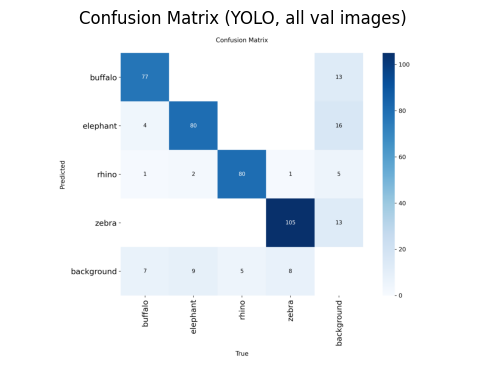

In [12]:
# Make sure plots show inside the notebook
%matplotlib inline
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")

from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os

# -------------------------------
# 1) Paths: weights + data.yaml
# -------------------------------
weights = r"runs\african\weights\best.pt"     # <- change to your best.pt if needed
DATA_ROOT = Path(r"C:\Users\Owner\datasets\african-wildlife")
yaml_path = DATA_ROOT / "data.yaml"           # the one we created earlier

assert Path(weights).exists(), f"Weights not found: {weights}"
assert yaml_path.exists(), f"data.yaml not found: {yaml_path}"

# -------------------------------
# 2) Load model and run VAL
#    This will run on ALL images in the val split
#    and create a confusion_matrix.png for you
# -------------------------------
model = YOLO(weights)

results = model.val(
    data=str(yaml_path),
    split="val",     # use the 'val' images from data.yaml
    imgsz=512,
    conf=0.25,
    iou=0.7,
    plots=True,      # <-- important: tells YOLO to save confusion matrix & curves
    workers=0
)

print("Validation results saved in:", results.save_dir)

# -------------------------------
# 3) Find and display confusion_matrix.png
# -------------------------------
cm_candidates = list(Path(results.save_dir).glob("confusion_matrix*.png"))
if not cm_candidates:
    raise FileNotFoundError("confusion_matrix.png not found in results folder.")

cm_path = cm_candidates[0]
print("Using confusion matrix:", cm_path)

img = Image.open(cm_path)
plt.figure(figsize=(6,5))
plt.imshow(img)
plt.axis("off")
plt.title("Confusion Matrix (YOLO, all val images)")
plt.show()


Ultralytics 8.3.237  Python-3.13.5 torch-2.8.0+cpu CPU (Intel Core i5-7300HQ 2.50GHz)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 414.5473.2 MB/s, size: 87.8 KB)
val: Scanning C:\Users\Owner\datasets\african-wildlife\labels\val.cache... 225 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 225/225 375.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 1.3it/s 11.9s1.0s
                   all        225        379      0.925      0.876      0.932      0.793
               buffalo         62         89      0.937      0.841      0.923      0.801
              elephant         53         91      0.908      0.863      0.913      0.776
                 rhino         55         85      0.918      0.906       0.95      0.828
                 zebra         59        114      0.936      0.893      0.942      0.766
Speed: 0.7ms preproces

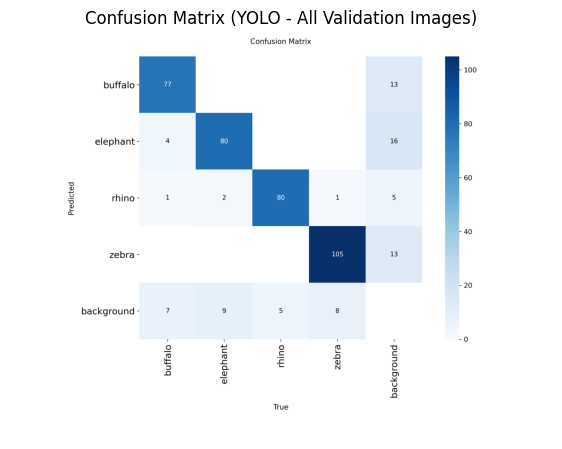

Saved copy to: C:\Users\Owner\datasets\african-wildlife\confusion_matrix_saved.png


In [13]:
# Make sure plots display inside Jupyter
%matplotlib inline
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")

from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os

# -----------------------------------
# 1) Load model and dataset config
# -----------------------------------
weights = r"runs/african/weights/best.pt"     # <-- update if needed
DATA_ROOT = Path(r"C:\Users\Owner\datasets\african-wildlife")
yaml_path = DATA_ROOT / "data.yaml"

assert Path(weights).exists(), f"Weights not found: {weights}"
assert yaml_path.exists(), f"data.yaml not found: {yaml_path}"

model = YOLO(weights)

# -----------------------------------
# 2) Run validation on ALL images in val split
#    YOLO will auto-create confusion_matrix.png
# -----------------------------------
results = model.val(
    data=str(yaml_path),
    split="val",
    imgsz=512,
    conf=0.25,
    iou=0.7,
    plots=True,      # <-- MUST BE TRUE to create confusion matrix
    workers=0
)

print("Validation folder:", results.save_dir)

# -----------------------------------
# 3) Find YOLO-generated confusion_matrix.png
# -----------------------------------
cm_candidates = list(Path(results.save_dir).glob("confusion_matrix*.png"))
if len(cm_candidates) == 0:
    raise FileNotFoundError("No confusion_matrix.png created. Ensure plots=True during val().")

cm_path = cm_candidates[0]
print("Confusion matrix file:", cm_path)

# -----------------------------------
# 4) Display confusion matrix in notebook
# -----------------------------------
img = Image.open(cm_path)
plt.figure(figsize=(7,6))
plt.imshow(img)
plt.axis("off")
plt.title("Confusion Matrix (YOLO - All Validation Images)")
plt.show()

# -----------------------------------
# 5) Image saved to path
# -----------------------------------
save_copy_path = DATA_ROOT / "confusion_matrix_saved.png"
img.save(save_copy_path)
print("Saved copy to:", save_copy_path)


In [14]:
import cv2
import math
cv2.__version__

'4.12.0'

In [15]:
print("Model will attempt to predict:")

for i in range(0, len(model.names)):
    print("Class", str(i) + ":", model.names[i])

Model will attempt to predict:
Class 0: buffalo
Class 1: elephant
Class 2: rhino
Class 3: zebra


In [19]:
# Number of video sources/cameras to check access
sources = 5
# Size of frame
size = [800, 640]

# Attempt to access first available camera, out of [sources] cameras
for i in range(0, sources+1):
    print("Attempting to connect to source {0}.\n".format(i))
    camera = cv2.VideoCapture(i)
    camera.set(3, size[0])
    camera.set(4, size[1])
    if camera.isOpened():
        print("Connected to source {0}.".format(i))
        connected = True
        break
    else:
        print("Cannot connect to source.")
        connected = False
        if i < sources:
            print("Changing source.\n\n")
        else:
            print("No source available to connect.")

Attempting to connect to source 0.

Connected to source 0.


In [20]:
# These values only need to be initialized once
exitKey = 'q'
frameName = "Test Capture"

# Editable box design values
boxColor = (255, 120, 175)
boxThickness = 2

# Editable text/frame values
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.75
fontColor = (255, 255, 255)
fontThickness = 2

while connected:
    capturing, frame = camera.read()
    
    if capturing:
        # Run object detection on captured frame
        results = model(frame, stream=True)

        # Use detection results to draw boxes
        for result in results:
            item = result.boxes
            
            for box in item:
                # Obtain Top-Left and Bottom-Right x/y values
                xTL, yTL, xBR, yBR = box.xyxy[0]
                # Convert to percent and truncate to hundredths place
                confidence = math.floor((box.conf[0])*10000)/100
                
                cv2.rectangle(frame, (int(xTL), int(yTL)), (int(xBR), int(yBR)), boxColor, boxThickness)

                classType = int(box.cls[0])
                classAndConfidence = model.names[classType]

                cv2.putText(frame, classAndConfidence, (int(xTL), int(yTL)), font, fontScale, fontColor, fontThickness)
                # Statement below will print to output, but not to frame
                print(model.names[classType], confidence)

        # Display captured frame, including drawn boxes
        cv2.imshow(frameName, frame)

        # Will wait for key exitKey to be pressed
        # Case-sensitive, 'Q' != 'q' and will require [Shift] to be pressed
        if cv2.waitKey(1) & 0xFF == ord(exitKey):
            break
            
    # Break loop if capturing is interrupted
    if not capturing:
        print("Failed to capture.")
        break
        
camera.release()
cv2.destroyAllWindows()


0: 384x512 1 elephant, 52.1ms
elephant 27.82
Speed: 2.0ms preprocess, 52.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)

0: 384x512 1 elephant, 70.7ms
elephant 29.37
Speed: 2.9ms preprocess, 70.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 512)

0: 384x512 1 elephant, 113.9ms
elephant 29.37
Speed: 5.4ms preprocess, 113.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)

0: 384x512 (no detections), 57.8ms
Speed: 1.9ms preprocess, 57.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 512)

0: 384x512 1 elephant, 56.6ms
elephant 34.14
Speed: 1.8ms preprocess, 56.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 512)

0: 384x512 1 elephant, 70.2ms
elephant 34.14
Speed: 1.7ms preprocess, 70.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 512)

0: 384x512 1 elephant, 66.4ms
elephant 42.71
Speed: 2.2ms preprocess, 66.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 512)

0: 384

In [ ]:
# In case of successful camera access, but error in drawing/displaying frame in previous cell preventing loop breaking
camera.release()
cv2.destroyAllWindows()